Machine Learning project: Laura Calzoni, Francesca Paradiso

# Prediction over the Titanic dataset

The aim of the project is to predict the survival state of a passenger on the Titanic, basing on some data provided.

(Note on the project result: each time the script is run the data relative to stochastic decisions could change from the one shown in the report)

We import all the necessary libraries to develope the project

In [123]:
# linear algebra
import numpy as np 
import random

# data processing
import pandas as pd 
import csv

# data visualization
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from scipy import stats

# Algorithms
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

#Evaluation tools
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

augmentation = False


# 1. Data exploration

We upload the dataset by reading the Titanic.csv file provided and we plot the information contained in such file (number of samples available and characteristics of the data contained).

In [124]:
dataset = pd.read_csv("Titanic.csv")
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Sex          889 non-null    object 
 4   Age          889 non-null    float64
 5   SibSp        889 non-null    int64  
 6   Parch        889 non-null    int64  
 7   Fare         889 non-null    float64
 8   Embarked     889 non-null    int64  
dtypes: float64(2), int64(6), object(1)
memory usage: 62.6+ KB


In [125]:
dataset.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,446.000000,0.382452,2.311586,35.686355,0.524184,0.382452,32.096681,2.535433
std,256.998173,0.486260,0.834700,17.756733,1.103705,0.806761,49.697504,0.792088
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,1.000000
25%,224.000000,0.000000,2.000000,22.000000,0.000000,0.000000,7.895800,2.000000
50%,446.000000,0.000000,3.000000,32.000000,0.000000,0.000000,14.454200,3.000000
75%,668.000000,1.000000,3.000000,54.000000,1.000000,0.000000,31.000000,3.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,3.000000


As an example, we display the first samples of our dataset

In [126]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,Male,22.0,1,0,7.2500,3
1,2,1,1,female,38.0,1,0,71.2833,1
2,3,1,3,female,26.0,0,0,7.9250,3
3,4,1,1,female,35.0,1,0,53.1000,3
4,5,0,3,Male,35.0,0,0,8.0500,3


In order to handle possible missing values on the dataset, we search for them in each given category, and plot the number of missing data counted. Since there are none, we won't have to fill any gap.

In [127]:
total = dataset.isnull().sum().sort_values(ascending=False)
percent_1 = dataset.isnull().sum()/dataset.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(10)

,Total,%
PassengerId,0,0.0
Survived,0,0.0
Pclass,0,0.0
Sex,0,0.0
Age,0,0.0
SibSp,0,0.0
Parch,0,0.0
Fare,0,0.0
Embarked,0,0.0


We analyse those that, for us, are most significant feature for our evaluation: Pclass, Sex, Fare

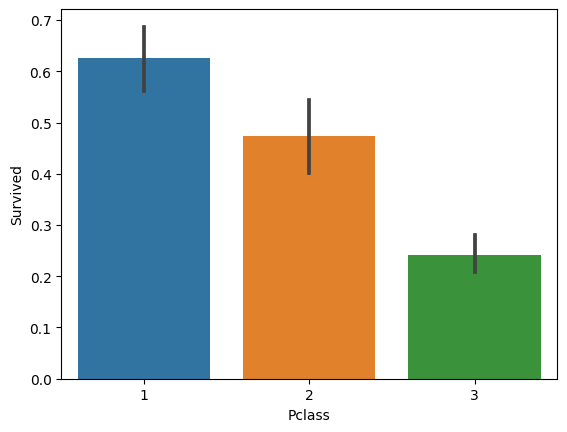

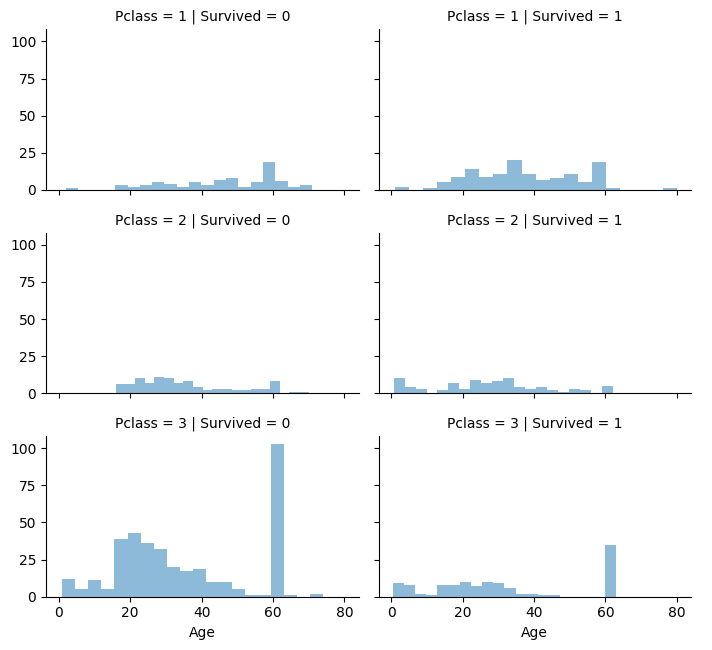

In [128]:
sns.barplot(x='Pclass', y='Survived', data=dataset)
grid = sns.FacetGrid(dataset, col='Survived', row='Pclass', height=2.2,aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

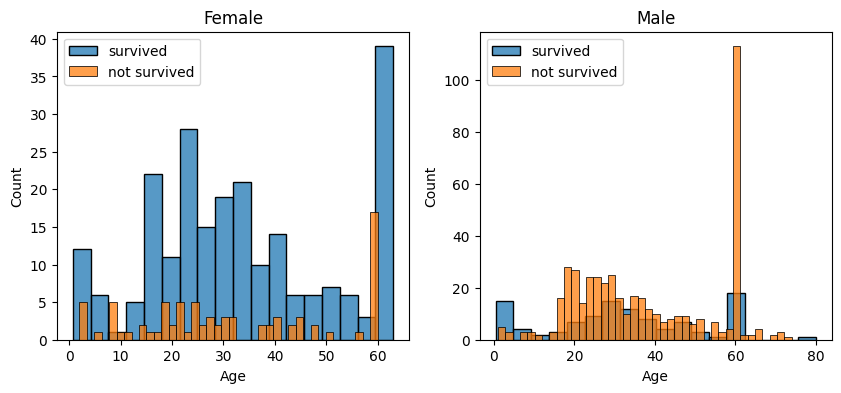

In [129]:
survived = 'survived'
not_survived = 'not survived'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
women = dataset[dataset['Sex']=='female']
men = dataset[dataset['Sex']=='Male']
ax = sns.histplot(women[women['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[0], kde =False)
ax = sns.histplot(women[women['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[0], kde =False)
ax.legend()
ax.set_title('Female')
ax = sns.histplot(men[men['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[1], kde = False)
ax = sns.histplot(men[men['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[1], kde = False)
ax.legend()
_ = ax.set_title('Male')

array([<Axes: ylabel='Survived'>], dtype=object)

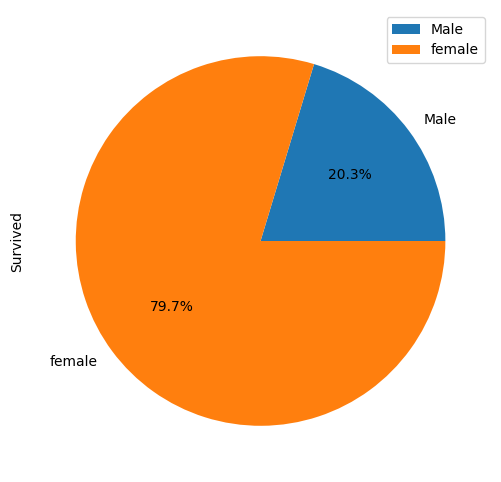

In [130]:
dataset[['Sex', 'Survived']].groupby(['Sex']).mean().plot.pie(subplots=True, figsize=(11, 6),autopct='%1.1f%%')

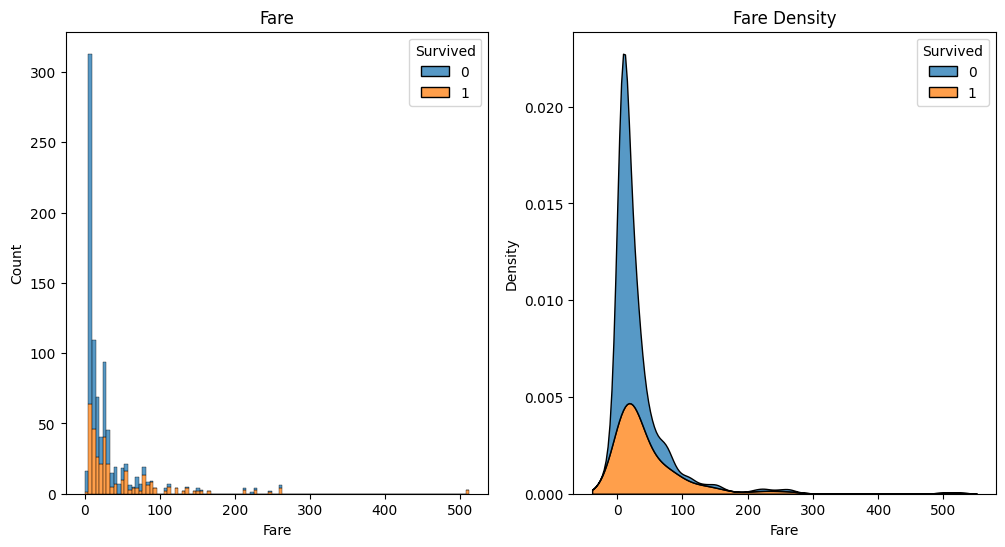

In [131]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(data=dataset, x="Fare", hue="Survived", multiple="stack", ax=axes[0])
axes[0].set_title("Fare")
sns.kdeplot(data=dataset, x="Fare", hue="Survived", multiple="stack", ax=axes[1])
axes[1].set_title("Fare Density")
plt.show()

We try to augment the dataset by adding new data to the csv file provided (even though this approach turned out to be unsuccessful). To do it, set augmentation=True at the begin of this script.

In [132]:
if augmentation:
    print(len(dataset))
    
    for i in range(100):
        passenger = 890+(1+i)
        survived = np.random.randint(2)
        if survived == 0:
            sex= 'Male'
        if survived ==1 :
            sex == 'female'
        # sex = random.choice(['Male', 'female'])
        Pclass = np.random.randint(1, 4)
        age = np.random.randint(25, 55)
        SibSp = np.random.randint(2)
        parch = 0 # np.random.randint(3)
        fare = np.random.randint(45)
        embarked = np.random.randint(1, 4)

        data= [passenger, survived, Pclass, sex, age, SibSp, parch, fare, embarked]

        file_csv = open('titanic.csv', mode='a')
        writer = csv.writer(file_csv)
        writer.writerow(data)


    print("Aggiunta dei dati al file CSV completata.")
    dataset = pd.read_csv("titanic.csv")
    print(len(dataset))
    file_csv.close()

By plotting the data through box plots, we can detect the presence of outliers and we procede removing them by checking the z-score for the categories involved.

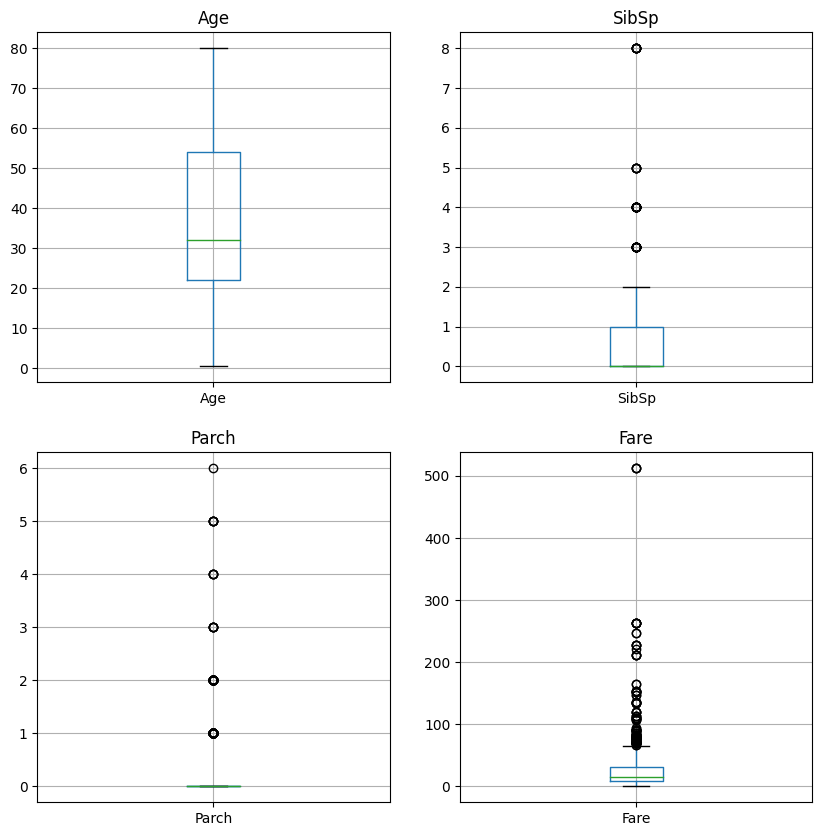

In [133]:
numerical_columns = ['Age', 'SibSp', 'Parch', 'Fare']  # Example numerical columns to check for outliers
# Create a 4x4 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 10))


for i, column in enumerate(numerical_columns):
    ax = axes[i // 2, i % 2]  # Get the current subplot
    dataset.boxplot(column=column, ax=ax)
    ax.set_title(column)

plt.show()

In [134]:
threshold = 3  # Set the threshold for Z-score

print("dataset with outliers: ", len(dataset))

z_scores_P = np.abs(stats.zscore(dataset['Parch']))
outlier_indices_P = list(np.where(z_scores_P > threshold)[0])
print("number of outliers in 'Parch': ", len(outlier_indices_P))

z_scores_S = np.abs(stats.zscore(dataset['SibSp']))
outlier_indices_S = list(np.where(z_scores_S > threshold)[0])
print("number of outliers in 'SibSp': ", len(outlier_indices_S))

z_scores_F = np.abs(stats.zscore(dataset['Fare']))
outlier_indices_F = list(np.where(z_scores_F > threshold)[0])
print("number of outliers in 'Fare': ", len(outlier_indices_F))

#Remove outliers
outlier_indices = list(set(outlier_indices_P+outlier_indices_S+outlier_indices_F))
dataset = dataset.drop(outlier_indices)

print("total number of outliers: ", len(outlier_indices))
print("dataset without outliers: ", len(dataset))

dataset with outliers:  889
number of outliers in 'Parch':  15
number of outliers in 'SibSp':  30
number of outliers in 'Fare':  20
total number of outliers:  64
dataset without outliers:  825


# 2. Feature Selection and Engineering

Now we modify some of the features in our dataset, in order to rewrite them in such a way to be properly elaborated by the learning algorithm. In particular, we transform all our features in integers, and we map the feauture "Sex", into a numerical one. 

In [135]:
dataset['Fare'] = dataset['Fare'].fillna(0)
dataset['Fare'] = dataset['Fare'].astype(int)

In [136]:
dataset['Age'] = dataset['Age'].fillna(0)
dataset['Age'] = dataset['Age'].astype(int)

In [137]:
sex_mapping = {"Male": 0, "female": 1}
dataset['Sex'] = dataset['Sex'].map(sex_mapping)

We also create some macro categories for the features that are more sparse, such as "Age" and "Fare"

In [138]:
dataset.loc[ dataset['Age'] <= 18, 'Age'] = 0
dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 25), 'Age'] = 1
dataset.loc[(dataset['Age'] > 25) & (dataset['Age'] <= 35), 'Age'] = 2
dataset.loc[(dataset['Age'] > 35) & (dataset['Age'] <= 50), 'Age'] = 3
dataset.loc[(dataset['Age'] > 50), 'Age'] = 4

# let's see how it's distributed 
dataset['Age'].value_counts()

Age
4    229
2    191
1    155
3    138
0    112
Name: count, dtype: int64

In [139]:
dataset.loc[ dataset['Fare'] <= 7, 'Fare'] = 0
dataset.loc[(dataset['Fare'] > 7) & (dataset['Fare'] <= 15), 'Fare'] = 1
dataset.loc[(dataset['Fare'] > 15) & (dataset['Fare'] <= 30), 'Fare']   = 2
dataset.loc[(dataset['Fare'] > 30), 'Fare']   = 3


dataset['Fare'].value_counts()

Fare
1    243
0    240
3    171
2    171
Name: count, dtype: int64

Additionally, we create a new feature called "Fare_Per_Person"

In [140]:
dataset['Fare_Per_Person'] = dataset['Fare']/(dataset['Parch']+dataset['SibSp']+1)
dataset['Fare_Per_Person'] = dataset['Fare_Per_Person'].astype(int)
dataset['Fare_Per_Person'].value_counts()

Fare_Per_Person
0    377
1    328
2     62
3     58
Name: count, dtype: int64

We delete also those features that we don't consider as relevant for our specific case, which are "PassengerId" and "Embarked"

In [141]:
dataset = dataset.drop("PassengerId", axis=1)
dataset = dataset.drop("Embarked", axis=1)

#We tried to eliminate "Parch" and "SibSp" too, but this choice led to worse results
# dataset = dataset.drop("Parch", axis=1)
# dataset = dataset.drop("SibSp", axis=1)

# 3. Model development and Evaluation

Now we divide our dataset into a Train set and a Test set, respectevely with 80% and 20% of the samples. Then we generate the data for training and testing by removing the "Survived" class from the two sets obtained, while we generate the respective labels by selecting only such variable in the two sets obtained

In [142]:
train, test = train_test_split(dataset, test_size=0.2, random_state=42)
print("Dimension of the train set:",train.shape)
print("Dimension of the test set:", test.shape)
X_train = train.drop("Survived", axis=1)
Y_train = train["Survived"]
X_test = test.drop("Survived", axis=1)
Y_test = test["Survived"]


Dimension of the train set: (660, 8)
Dimension of the test set: (165, 8)


Let's now train our data using different tools. We will select the one(s) which performs better.

In [143]:
#Random Forest
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)

#Decision Tree
decision_tree = DecisionTreeClassifier() 
decision_tree.fit(X_train, Y_train) 
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)

#Linear Support Vector Machine
linear_svc = LinearSVC(max_iter =2000)
linear_svc.fit(X_train, Y_train)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)

#Stochastic Gradient Descent
sgd = SGDClassifier(max_iter=5, tol=None)
sgd.fit(X_train, Y_train)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)

results = pd.DataFrame({
    'Model': [ 'Random Forest', 
              'Decision Tree',
              'Support Vector Machines',
              'Stochastic Gradient Descent'],
    'Score': [acc_random_forest,
              acc_decision_tree,
              acc_linear_svc,
              acc_sgd]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
result_df.head(5)


,Model
Score,
87.58,Random Forest
87.58,Decision Tree
79.24,Support Vector Machines
59.85,Stochastic Gradient Descent


The best results have been obtained using Random Forest and Decision Tree algorithms

Next, we check the importance the different features have during the training process, in order to eliminate the useless ones (if any)

In [144]:
importances = pd.DataFrame({'feature':X_train.columns,'DT feature importance':np.round(decision_tree.feature_importances_,3)})
importances = importances.sort_values('DT feature importance',ascending=False).set_index('feature')
importances.head(7)

,DT feature importance
feature,
Sex,0.460
Pclass,0.150
Age,0.119
Parch,0.084
Fare,0.078
Fare_Per_Person,0.061
SibSp,0.048


In [145]:
importances = pd.DataFrame({'feature':X_train.columns,'RF feature importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('RF feature importance',ascending=False).set_index('feature')
importances.head(7)

,RF feature importance
feature,
Sex,0.405
Age,0.177
Pclass,0.133
Fare,0.103
SibSp,0.068
Parch,0.066
Fare_Per_Person,0.048


As every features seems quite important in both cases, we decide to maintain all of them

We evaluate the performances of the best models by computing the Precisoin, Recall and F-score on the prediction. 

In [146]:
print("RANDOM FOREST:")
prediction_rf = random_forest.predict(X_train)
print(f"Precision: {round(precision_score(Y_train, prediction_rf)*100 ,2)} %" )
print(f"Recall: {round(recall_score(Y_train, prediction_rf)*100, 2 )} %")
print(f"F-score: {round(f1_score(Y_train, prediction_rf)*100, 2)} %" )

print("\nDECISION TREE:")
prediction_dt = decision_tree.predict(X_train)
print(f"Precision: {round(precision_score(Y_train, prediction_dt)*100 ,2)} %" )
print(f"Recall: {round(recall_score(Y_train, prediction_dt)*100, 2 )} %")
print(f"F-score: {round(f1_score(Y_train, prediction_dt)*100, 2)} %" )

RANDOM FOREST:
Precision: 88.84 %
Recall: 77.73 %
F-score: 82.92 %

DECISION TREE:
Precision: 91.04 %
Recall: 75.39 %
F-score: 82.48 %


Also, we perform K-Fold Cross Validation in order to see how the models generalize and perform on unseen data

In [74]:
#Choosing K=4

print("VALIDATION ON RANDOM FOREST")
rf = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rf, X_train, Y_train, cv=4, scoring = "accuracy")
print("Scores:", scores)
print(f"Mean: {scores.mean()*100} %")
print(f"Standard Deviation: {scores.std()*100} %")


print("\nVALIDATION ON DECISION TREE")
dt = DecisionTreeClassifier()
scores = cross_val_score(dt, X_train, Y_train, cv=4, scoring = "accuracy")
print("Scores:", scores)
print(f"Mean: {scores.mean()*100} %")
print(f"Standard Deviation: {scores.std()*100} %")

VALIDATION ON RANDOM FOREST
Scores: [0.81818182 0.8        0.76969697 0.81818182]
Mean: 80.15151515151516 %
Standard Deviation: 1.981317701609401 %

VALIDATION ON DECISION TREE
Scores: [0.84242424 0.81212121 0.73939394 0.80606061]
Mean: 80.0 %
Standard Deviation: 3.760507165451775 %


Finally, we try to fine-tuning the model using the GridSearchCV tool of scikit-learn for both the models.

In [437]:
print("FINE TUNING ON DECISION TREE")
param_grid = { "criterion" : ["gini", "entropy","log_loss"], 
              "splitter" : ['best', 'random'],
              "min_samples_leaf" : [1, 5, 10], 
              "min_samples_split" : [2, 4, 10], 
              "max_depth": [None, 5, 10],
              "random_state": [None, 1, 42],}
dt = DecisionTreeClassifier()
clf = GridSearchCV(estimator=dt, param_grid=param_grid, n_jobs=-1)

clf.fit(X_train, Y_train)
print(clf.best_params_)

acc_clf = clf.score(X_train, Y_train)*100
print(f"Accuracy on Training set: {acc_clf}  %")


FINE TUNING ON DECISION TREE


{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2, 'random_state': 1, 'splitter': 'random'}
Accuracy on Training set: 82.57575757575758  %


In [438]:
print("FINE TUNING ON RANDOM FOREST")
param_grid = { "criterion" : ["gini", "entropy"], 
              "min_samples_leaf" : [1, 5, 10, 25, 50, 70], 
              "min_samples_split" : [2, 4, 10, 12, 16, 18, 25, 35],
               "n_estimators": [100, 400, 700, 1000, 1500]}


rf = RandomForestClassifier(n_estimators=100, max_features='sqrt', oob_score=True, random_state=1, n_jobs=-1)
clf = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=-1)

clf.fit(X_train, Y_train)
print(clf.best_params_)

acc_clf = clf.score(X_train, Y_train)*100
print(f"Accuracy on Training set: {acc_clf} %")


FINE TUNING ON RANDOM FOREST
{'criterion': 'gini', 'min_samples_leaf': 5, 'min_samples_split': 35, 'n_estimators': 400}
Accuracy on Training set: 82.12121212121211 %


# 4. Prediction and Interpretation

Now we can use the best model obtained so far to our test set, in oder to predict the survival rate of a passenger. Then we evaulate the resulting accuracy.

In [76]:
print("DECISION TREE:")
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
decision_tree.score(X_train, Y_train)

acc_decision_tree = decision_tree.score(X_train, Y_train)*100
print(f"Training accuracy: {round(acc_decision_tree, 2)} %")


Y_pred = decision_tree.predict(X_test)
acc_decision_tree_pred = accuracy_score(Y_test, Y_pred)*100
print(f"Test accuracy: {round(acc_decision_tree_pred, 2)} %")

print("\nRANDOM FOREST:")
random_forest = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=1, n_jobs=-1)
random_forest.fit(X_train, Y_train)
random_forest.score(X_train, Y_train)

acc_random_forest = random_forest.score(X_train, Y_train)*100
print(f"Training accuracy: {round(acc_random_forest, 2)} %")


Y_pred = random_forest.predict(X_test)
acc_random_forest_pred = accuracy_score(Y_test, Y_pred)*100
print(f"Test accuracy: {round(acc_random_forest_pred, 2)} %")


DECISION TREE:
Training accuracy: 87.58 %
Test accuracy: 81.21 %

RANDOM FOREST:
Training accuracy: 87.58 %
Test accuracy: 84.24 %


In the end, the Random Forest model results to be the best option. So, we conclude by computing further evaluations on such model only. 

In particular, we calculate the Confusion Matrix of both the train and the test sets 

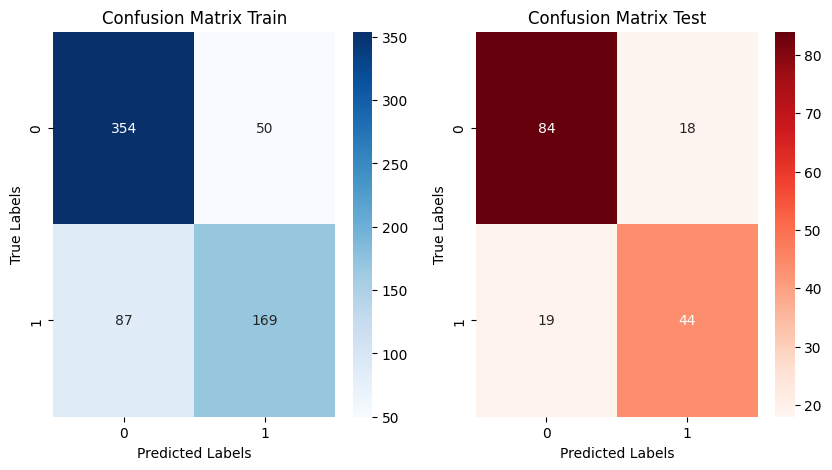

In [77]:
predictions = cross_val_predict(random_forest, X_train, Y_train, cv=3)
cm = confusion_matrix(Y_train, predictions)

predictions_test = cross_val_predict(random_forest, X_test, Y_test, cv=3)
cm_test = confusion_matrix(Y_test, predictions_test)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Confusion Matrix Train")
axes[0].set_xlabel("Predicted Labels")
axes[0].set_ylabel("True Labels")

sns.heatmap(cm_test, annot=True, fmt="d", cmap="Reds", ax=axes[1])
axes[1].set_title("Confusion Matrix Test")
axes[1].set_xlabel("Predicted Labels")
axes[1].set_ylabel("True Labels")

# Show the plot
plt.show()

And the Precision, Recall and F-score values obtained over the test set

In [78]:
print("\nTEST:")
print(f"Precision: {round(precision_score(Y_test, Y_pred)*100, 2)} %" )
print(f"Recall: {round(recall_score(Y_test, Y_pred)*100, 2)} %" )
print(f"F-score: {round(f1_score(Y_test, Y_pred)*100, 2)} %" )


TEST:
Precision: 86.27 %
Recall: 69.84 %
F-score: 77.19 %
